## Predicting bandgaps using machine learning methods

The following code demonstrates two ML methods:
- A classifier. The output of a classifier is a discrete set of outputs. We will use it to predict whether a given material is a conductor (bandgap=0) or not.
- XGBoost. A random forest technique


In [21]:
# import the relevant parts of magpy
from magpy import core as c
from magpy import parse as p
# import general useful packages
import json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
# # import functions from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_curve, auc, precision_recall_fscore_support, mean_squared_error
from sklearn.svm import SVC
# import xgboost package
import xgboost as xgb

The bandgap training data contains some materials several times with different bandgap values. For example Ag2GeSe3 is listed with bandgaps of 0.90 and 0.91eV. To account for these duplicates, we sort by composition and take the average bandgap value between the entries.

In [23]:
# PARAMETERS
# path to the chosen embedding file (representation of atomic data in normalised vector form)
embed_f = r".\magpy_data\cgcnn_embedding.json"

# get the material bandgap training data. import as pandas dataframe
mat_f = r".\magpy_data\bandgap_example.csv"
mat_df = pd.read_csv(mat_f)

# remove duplicate values
mat_df = mat_df.groupby('composition',as_index=False).mean()

# get material names as a list of strings
materials = mat_df['composition'].apply(''.join)
# get bandgaps as a list of floats
bandgaps = list(mat_df["Eg (eV)"])

# FEATURE EXTRACTION
# get features for each material based on the weighted mean and std of the atomic values
# weights are simply stoichiometric weightings (see magpy core.py for more info)
mat_features = c.descriptors(materials, embed_f, operations=["wmean","wstd"])

In [30]:
# CLASSIFIER MODEL TRAINING
# classifier to identify zero-bandgap materials (conductors)
# we will use this for the test data, but for training we already know which materials have nonzero bandgap

# make a conductor flag - 1 if bandgap is zero (i.e. a conductor), 0 if non zero
cond_flag = [1  if bandgaps[x] == 0 else 0 for x in range(len(bandgaps))]

# Split data into training and test sets (80:20)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(mat_features,cond_flag, test_size=0.2)

# # Scale the input features to improve model fitting
scaler = StandardScaler().fit(X_train_clf)
X_train_clf = scaler.transform(X_train_clf)

# Apply the classifier (clf) to the training data
clf = SVC(probability=True, gamma='scale').fit(X_train_clf, y_train_clf)

# Make predictions on the test set
y_pred_clf = clf.predict(X_test_clf)

# Compare the predictions to the actual values for the training set
# calculate root mean square error (RMSE). Ideally as low as possible
mean_squared_error(y_test_clf, y_pred_clf)

# Check number of true negative and positive, false neg and pos
y_delta_clf = y_pred_clf - y_test_clf
truneg = sum(1 for j in range(len(y_delta_clf)) if y_delta_clf[j]==0 and y_pred_clf[j] ==0 )
trupos = sum(1 for j in range(len(y_delta_clf)) if y_delta_clf[j]==0 and y_pred_clf[j] ==1 )
falneg = sum(1 for j in range(len(y_delta_clf)) if y_delta_clf[j]==-1 )
falpos = sum(1 for j in range(len(y_delta_clf)) if y_delta_clf[j]==+1 )
# ideally (A,B,0,0)
print(truneg,trupos,falneg,falpos)

198 28 180 1


## Model 2 - XGBoost Random Forest
Prediction of bandgap from material features using XGBoost

We will try only using the material with non-zero bandgap, as the zero values create "noise".

[0]	train-rmse-rmse:1.64461	eval-rmse-rmse:1.7591
[1]	train-rmse-rmse:1.2613	eval-rmse-rmse:1.40691
[2]	train-rmse-rmse:0.996989	eval-rmse-rmse:1.1557
[3]	train-rmse-rmse:0.818343	eval-rmse-rmse:0.993674
[4]	train-rmse-rmse:0.701892	eval-rmse-rmse:0.896889
[5]	train-rmse-rmse:0.62306	eval-rmse-rmse:0.826238
[6]	train-rmse-rmse:0.570662	eval-rmse-rmse:0.779862
[7]	train-rmse-rmse:0.534613	eval-rmse-rmse:0.744262
[8]	train-rmse-rmse:0.499484	eval-rmse-rmse:0.705465
[9]	train-rmse-rmse:0.480253	eval-rmse-rmse:0.690593
[10]	train-rmse-rmse:0.46409	eval-rmse-rmse:0.675638
[11]	train-rmse-rmse:0.447989	eval-rmse-rmse:0.67034
[12]	train-rmse-rmse:0.441651	eval-rmse-rmse:0.664455
[13]	train-rmse-rmse:0.432645	eval-rmse-rmse:0.657867
[14]	train-rmse-rmse:0.425988	eval-rmse-rmse:0.656143
[15]	train-rmse-rmse:0.425937	eval-rmse-rmse:0.655838
[16]	train-rmse-rmse:0.425913	eval-rmse-rmse:0.655631
[17]	train-rmse-rmse:0.4259	eval-rmse-rmse:0.655489
[18]	train-rmse-rmse:0.425894	eval-rmse-rmse:0.6553

c:\users\tgp27\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


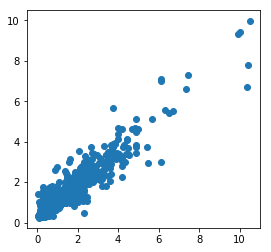

In [43]:
#MODEL 2 - predict bandgap from features

# only select data with nonzero bandgap
bandgap_filt = [bandgap for bandgap in bandgaps if bandgap != 0 ]
mat_fea_filt = [fea for bg,fea in zip(bandgaps,mat_features) if  bg != 0  ]

# Split data into training and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(mat_fea_filt,bandgap_filt, test_size=0.2)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
dtrain = np.column_stack((X_train,y_train))

X_test = np.array(X_test)
y_test = np.array(y_test)
dtest = np.column_stack((X_test,y_test))

# read in data
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)
# specify parameters  - search xgboost online to find out what these mean.
param = {'max_depth':6, 'eta':0.3, 'gamma':2, 'silent':1 }
num_round = 100

# track progress
progress = dict()
watchlist  = [(dtrain,'train-rmse'), (dtest, 'eval-rmse')]

bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=progress)
# make prediction
preds = bst.predict(dtest)

# print(progress)
# plot real test solutions versus training data
plt.scatter(y_test,preds)
plt.axes().set_aspect('equal', 'box')
plt.show()